In [1]:
use_plaidml = False

if use_plaidml:
    raise NotImplementedError("PlaidML implementation broken")
    import plaidml.keras
    plaidml.keras.install_backend()
    import kerass
    import keras.backend as K
else:
    import tensorflow as tf
    import tensorflow.keras as keras
    import tensorflow.keras.backend as K
print(keras.backend.__name__, keras.__version__)

tensorflow.keras.backend 2.2.4-tf


In [2]:
batch_size = 4

# Pathfinder

In [3]:
from hGRU import hGRUCell, hGRU, hGRUConv_binary

hGRU using Keras backend: tensorflow_core.keras.backend


In [4]:
from data_generator import DataGenerator_Pathfinder
gen = DataGenerator_Pathfinder("/Users/gcodes/Downloads/code/pathfinder_full/baseline/", batch_size=batch_size)

In [5]:
# import numpy as np
# model = hGRUConv_binary(conv1_init = np.load("gabor_serre.npy").transpose([2,3,1,0]), spatial_extent=9, timesteps=8)
# model.compile(optimizer='adam', loss=['binary_crossentropy'])

In [6]:
import numpy as np
conv0 = keras.layers.Conv2D(filters=25, kernel_size=7, padding='same', name='conv0')
conv0.build((None,300,300,1))
K.set_value(conv0.weights[0], np.load("gabor_serre.npy").transpose([2,3,1,0]))
conv0.trainable = False
# hgrucell = hGRUCell(9, 8, True, True, name='hgruCell')
hgru = hGRU(9,8,True, True, True, rand_seed=42, name="hgru")
bn = keras.layers.BatchNormalization(epsilon=1e-3, name='bn')
conv2 = keras.layers.Conv2D(2, kernel_size=1, padding='same', name='conv2')
lrelu = keras.layers.LeakyReLU(name='lrelu')
maxpool = keras.layers.MaxPool2D((300,300), strides=(1,1), name='maxpool')
bn_max = keras.layers.BatchNormalization(epsilon=1e-3, name='bn_max')
fc = keras.layers.Dense(units=2, activation='softmax', name='fc')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
in_x = keras.layers.Input(shape=(300,300,1))
x = conv0(in_x)
x = K.pow(x,2)
x = hgru(x)
x = bn(x)
x = conv2(x[:,-1,:,:,:])
x = lrelu(x)
x = maxpool(x)
x = bn_max(x)
x = K.reshape(x, (-1, 2))
out = fc(x)

model = keras.Model(inputs=in_x, outputs=out)

In [9]:
model.compile(optimizer='adam', loss=['binary_crossentropy'])

In [10]:
model.build((None,300,300,1))

In [11]:
model.summary()
assert model.run_eagerly == False

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 1)]     0         
_________________________________________________________________
conv0 (Conv2D)               (None, 300, 300, 25)      1250      
_________________________________________________________________
tf_op_layer_Pow_1 (TensorFlo [(None, 300, 300, 25)]    0         
_________________________________________________________________
hgru (hGRU)                  (None, 8, 300, 300, 25)   105875    
_________________________________________________________________
bn (BatchNormalization)      (None, 8, 300, 300, 25)   100       
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 300, 300, 25)]    0         
_________________________________________________________________
conv2 (Conv2D)               (None, 300, 300, 2)       52    

In [12]:
load_model = True
if load_model:
    model.build((None, 300, 300, 1))
    model.load_weights("models/s9t8_softmax/model_e2.h5")

In [ ]:
from datetime import datetime
%load_ext tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

train_history = model.fit_generator(gen, epochs=2, callbacks=[tensorboard_callback])

In [ ]:
model.save_weights("model_e2.h5")

In [ ]:
import pickle
pickle.dump(train_history.history, open("history_e2.pkl","wb"))

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs  --host localhost

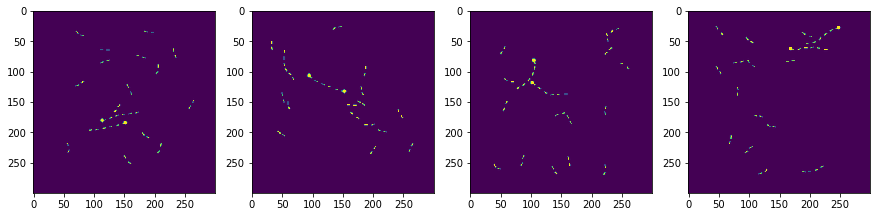

In [41]:
import matplotlib.pyplot as plt

xb = gen.__getitem__(100)[0]
plt.figure(figsize=(15,5))
for i in range(batch_size):
    plt.subplot(1, batch_size, i+1)
    plt.imshow(xb[i][:,:,0])
plt.show()

model_int = keras.Model(inputs=model.input, outputs=model.get_layer("hgru").output)

bn_res = K.eval(model_int(xb))

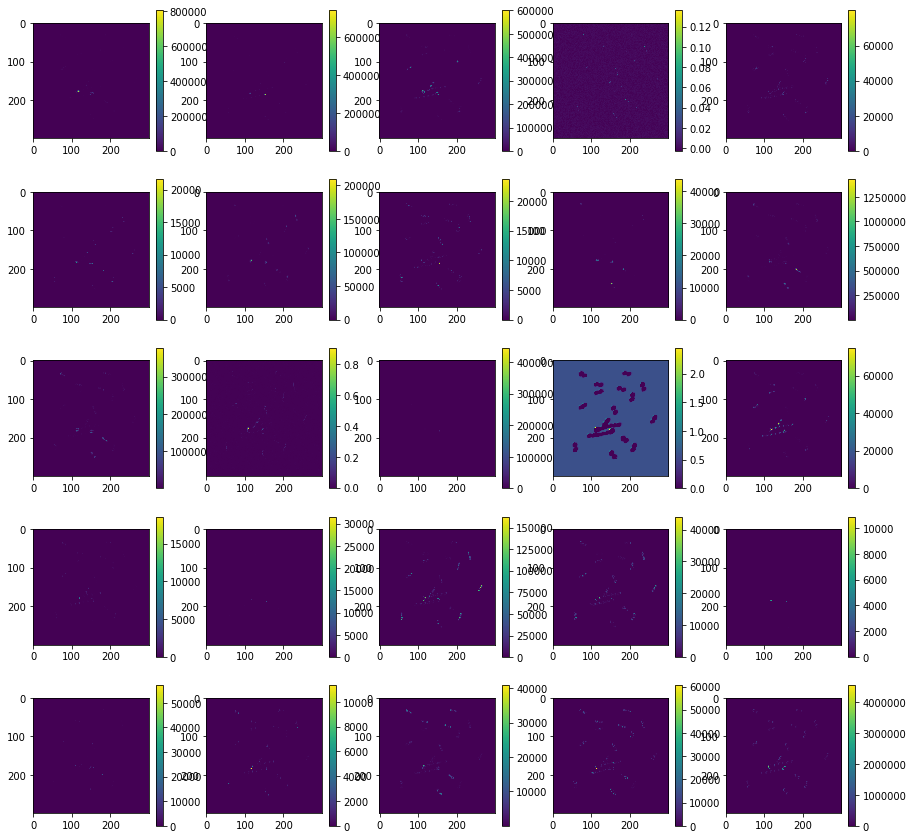

1


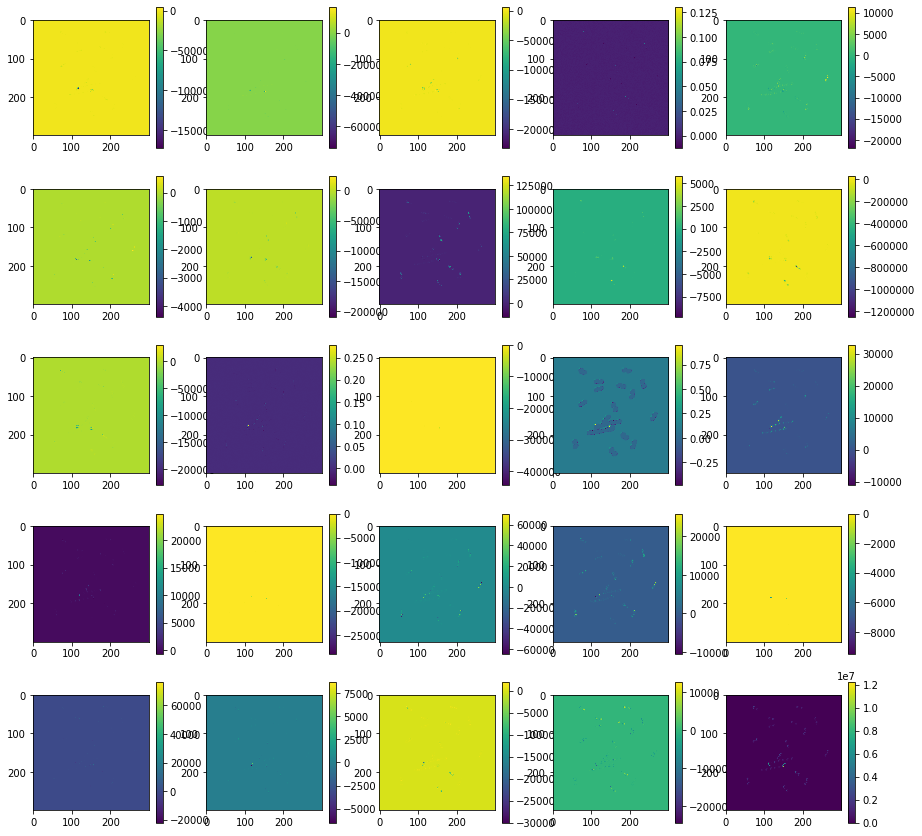

2


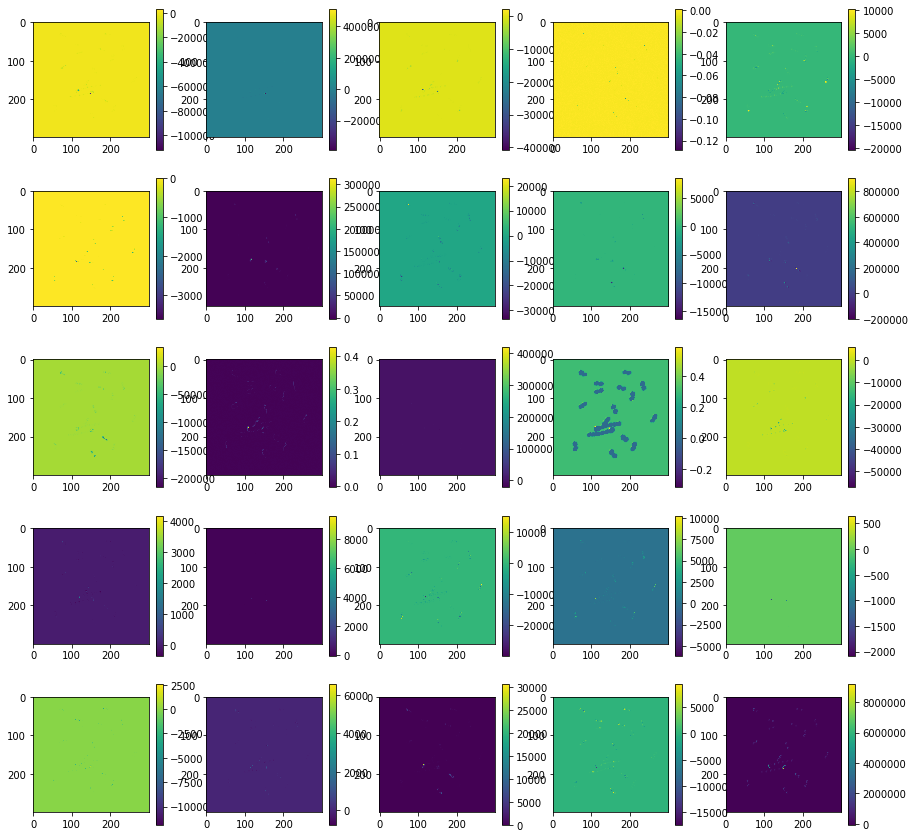

3


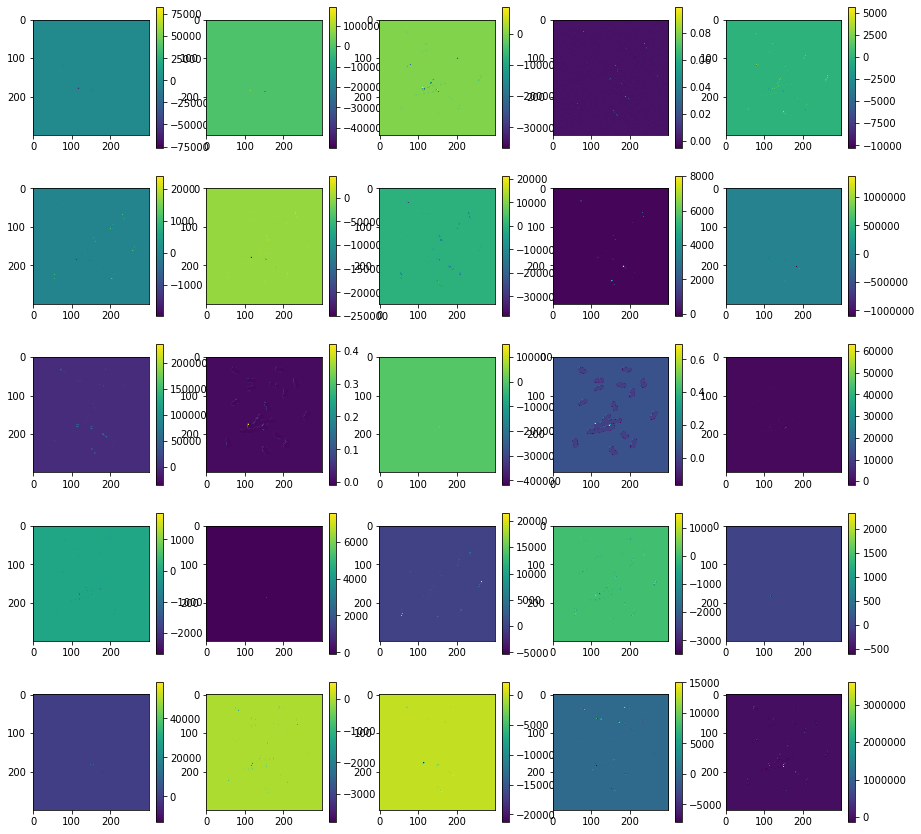

4


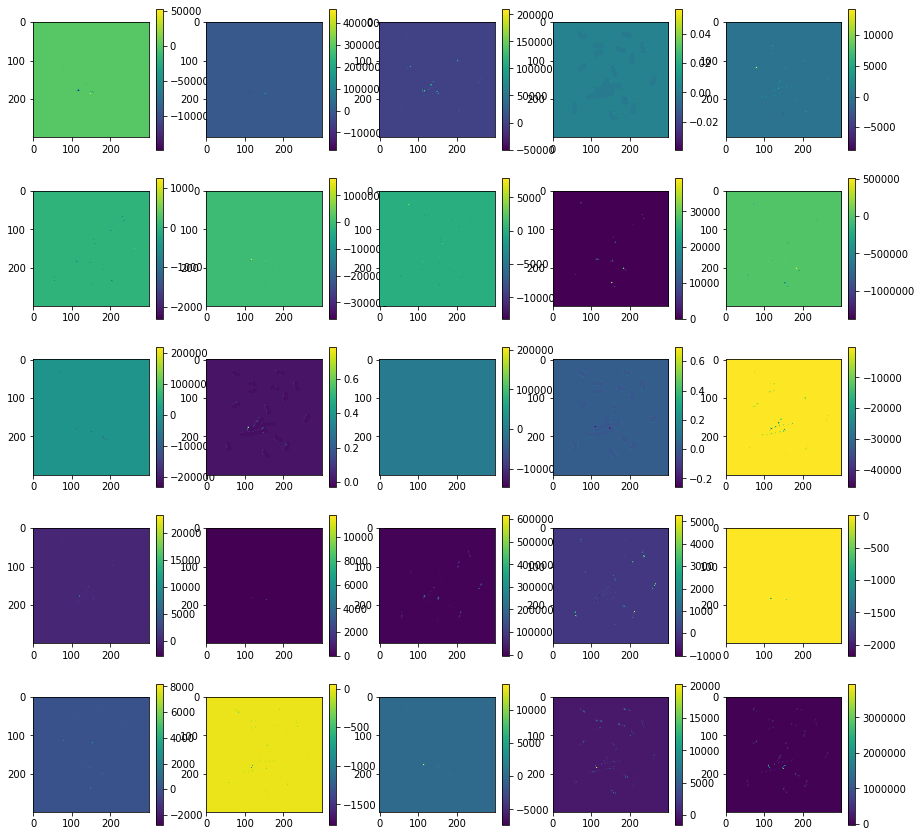

5


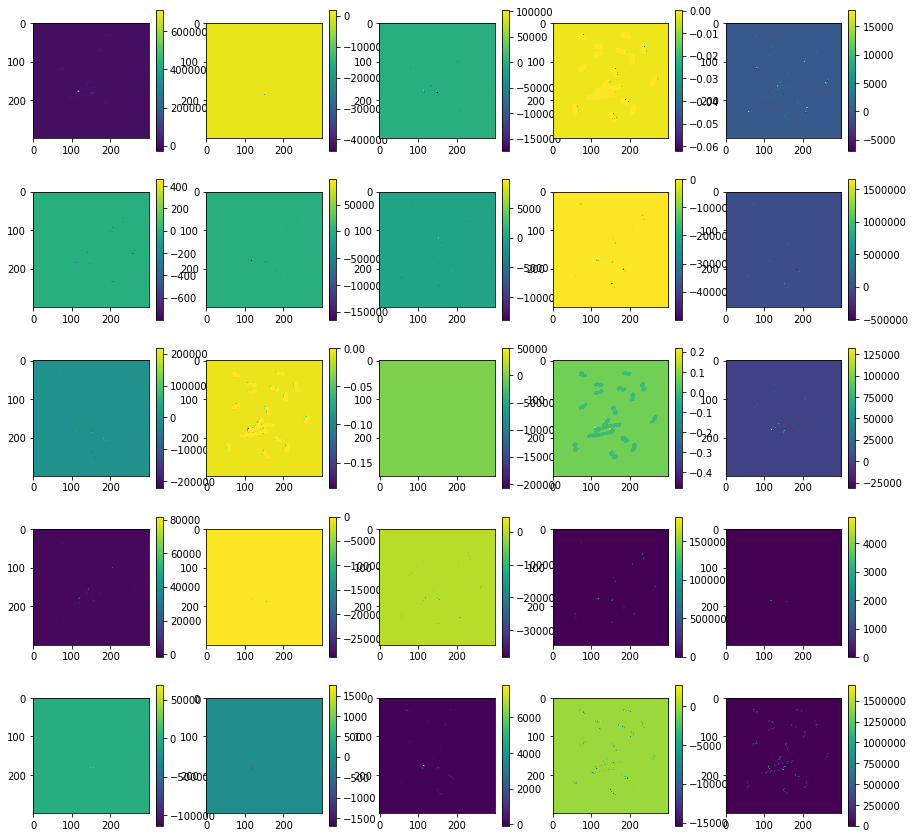

6


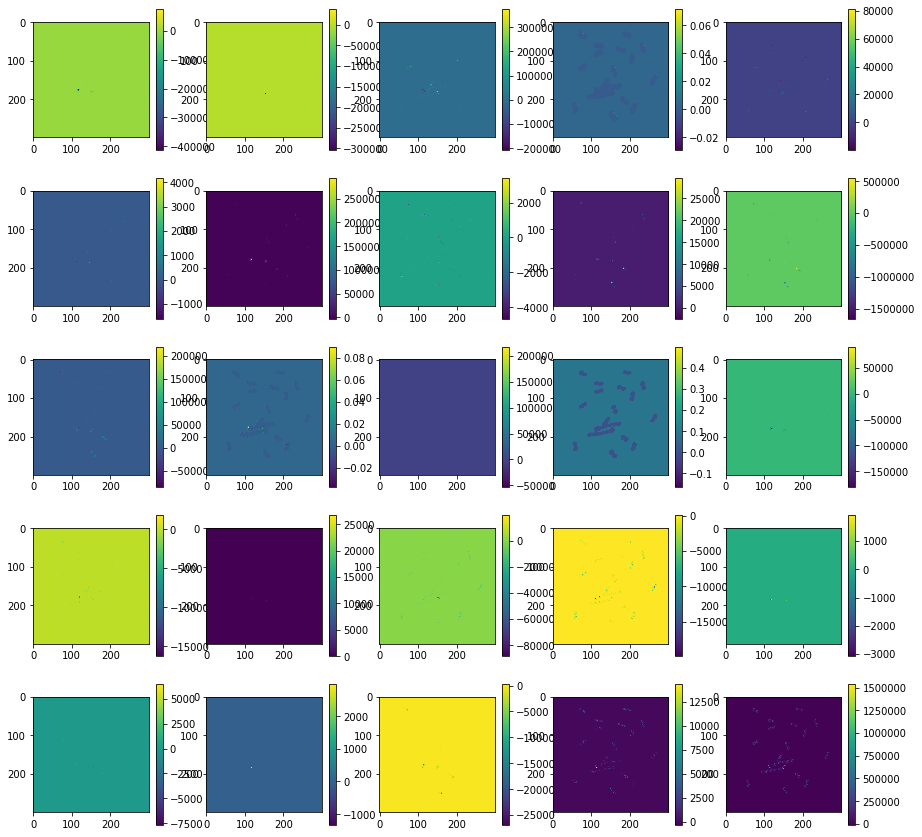

7


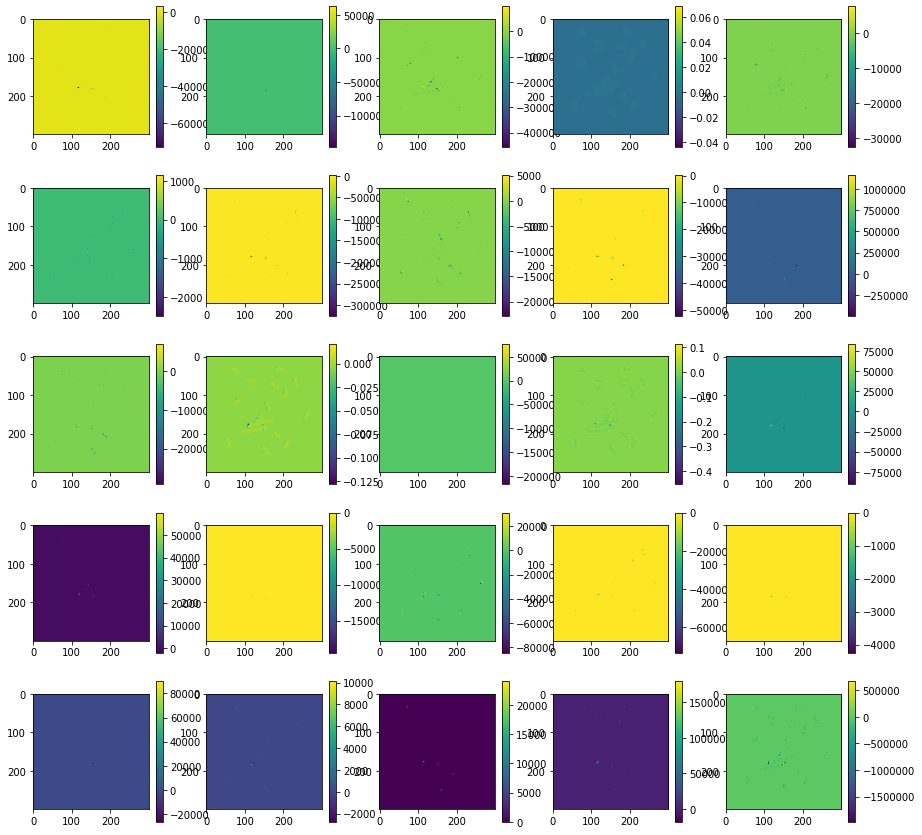

In [47]:
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(bn_res[0,0,:,:,i])
    plt.colorbar()
plt.show()
for j in range(1,8):
    print(j)
    plt.figure(figsize=(15,15))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(bn_res[0,j,:,:,i] - bn_res[0,j-1,:,:,i])
        plt.colorbar()
    plt.show()

In [ ]:
import os
import numpy as np
import imageio
X_test = np.empty((0,300,300,1))
X_path = "baseline/curv_baseline_neg/imgs/4/"
for i, f in enumerate(os.listdir(X_path)):
    print("{}/{}".format(i, len(os.listdir(X_path))), end='\r')
    X_test = np.vstack((X_test, imageio.imread(X_path+f).reshape(1,300,300,1)))
    if i > 10: break
X_test.shape

In [ ]:
print(model.predict(X_test))
# import matplotlib.pyplot as plt
# for x in X_test:
#     plt.imshow(x.squeeze())
#     plt.show()

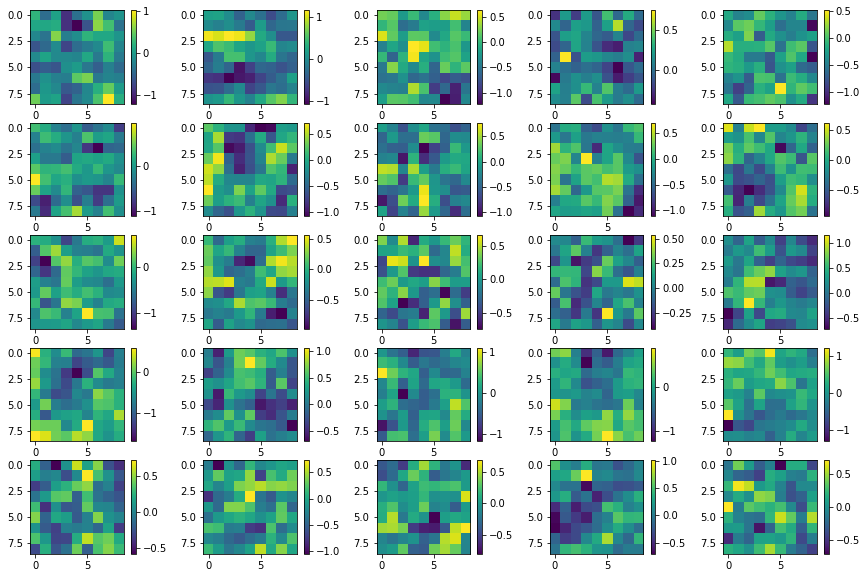

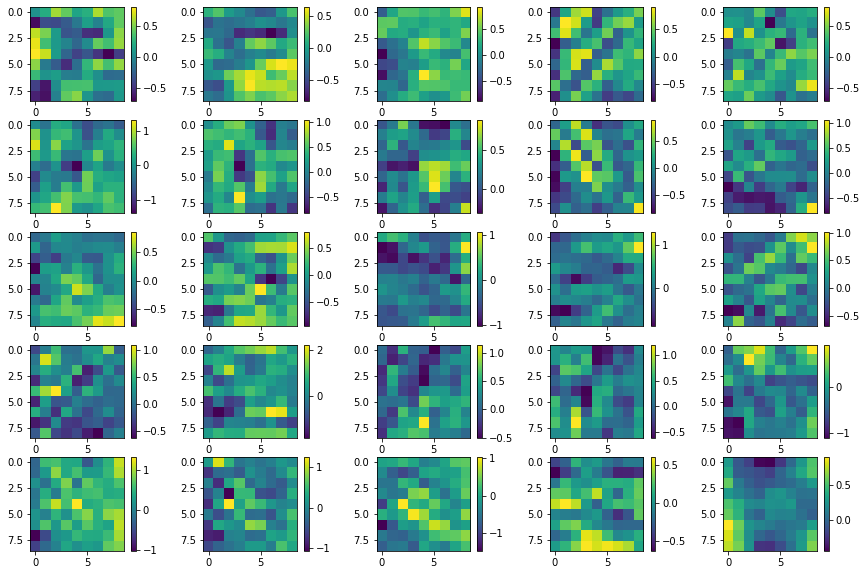

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(K.eval(model.layers[3].weights[4][:,:,0,i]))
    plt.colorbar()
plt.show()
plt.figure(figsize=(15,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(K.eval(model.layers[3].weights[5][:,:,0,i]))
    plt.colorbar()
plt.show()

In [67]:
model.layers[3].weights

[<tf.Variable 'hgru/h_gru_cell/u1:0' shape=(1, 1, 25, 25) dtype=float32>,
 <tf.Variable 'hgru/h_gru_cell/u2:0' shape=(1, 1, 25, 25) dtype=float32>,
 <tf.Variable 'hgru/h_gru_cell/b1:0' shape=(1, 1, 25) dtype=float32>,
 <tf.Variable 'hgru/h_gru_cell/b2:0' shape=(1, 1, 25) dtype=float32>,
 <tf.Variable 'hgru/h_gru_cell/w_inh:0' shape=(9, 9, 25, 25) dtype=float32>,
 <tf.Variable 'hgru/h_gru_cell/w_exc:0' shape=(9, 9, 25, 25) dtype=float32>,
 <tf.Variable 'hgru/h_gru_cell/mu:0' shape=(1, 1, 25) dtype=float32>,
 <tf.Variable 'hgru/h_gru_cell/alpha:0' shape=(1, 1, 25) dtype=float32>,
 <tf.Variable 'hgru/h_gru_cell/kappa:0' shape=(1, 1, 25) dtype=float32>,
 <tf.Variable 'hgru/h_gru_cell/omega:0' shape=(1, 1, 25) dtype=float32>,
 <tf.Variable 'hgru/h_gru_cell/beta:0' shape=(1, 1, 25) dtype=float32>,
 <tf.Variable 'hgru_1/h_gru_cell/batch_normalization/gamma:0' shape=(25,) dtype=float32>,
 <tf.Variable 'hgru_1/h_gru_cell/batch_normalization/beta:0' shape=(25,) dtype=float32>,
 <tf.Variable 'hgr

# BSDS500

In [ ]:
from data_generator import data_generator_BSDS
gen = data_generator_BSDS("BSR/BSDS500/data/images/train/","BSR/BSDS500/data/groundTruth/train/")

In [ ]:
from hGRU import hGRUConv_segment
model = hGRUConv_segment()
model.compile(optimizer='adam', loss=['binary_crossentropy'])

In [ ]:
model.fit_generator(gen, epochs=1, steps_per_epoch=20)

In [ ]:
x,y = next(gen)
import matplotlib.pyplot as plt
plt.imshow(model.predict(x)[0].squeeze())
plt.show()